### Denoising ( Component separation )using Scaterring Covariance

This notebook provides a simplified example of how to use scattering covariance to distinguish between noise and the signal of interest. The observational data model $d$ is given by: 

$d = s + n$. 

In this context, $s$ is represented by a 2D smiley picture and $n$ is white noise. We assume there are $n_{noise}=100$ noise realizations. We define two loss functions: 

$L_1 = \sum_{n_{noise}}{\frac{{(\Phi(d)-\Phi(s+n))}^2}{\sigma_{n}^2}}$, 

and 

$L_2 = \sum_{n_{noise}}{\frac{{(\Phi(d,s)-\Phi(s+n,s))}^2}{\sigma_{x}^2}}$.

Given that noise-induced biases are related to the signal of interest, the algorithm employs two iteration types. The first type minimizes the $L_1$ and $L_2$ losses to produce a signal model $s*$. The second type, termed an epoch to avoid confusion, updates the definition of $s*$, where $s*$ is initially $d$ and subsequently is the retrieved $s$ from the prior epoch. Consequently, $\sigma_{n}$ is the standard deviation of $\Phi(s*+n)-\Phi(s*)$, and $\sigma_{x}$ is the standard deviation of $\Phi(s*+n,s*)-\Phi(s*,s*)$.

The quality of the denoising is related to the number of noise used. This is constrained by the GPU memory. You can change this number in the cell 2 if you want a better result.

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import foscat.Synthesis as synthe

## Initialize data

The signal of interest is a 2D smiley picture downgraded to xsize=64 to make it run faster. The value range is [0,1].

In [2]:
xsize=64
# number of noise to learn statistics
nnoise=100

# amplitude of the white noise
ampnoise=0.3

# Load the smiley picture

([], [])

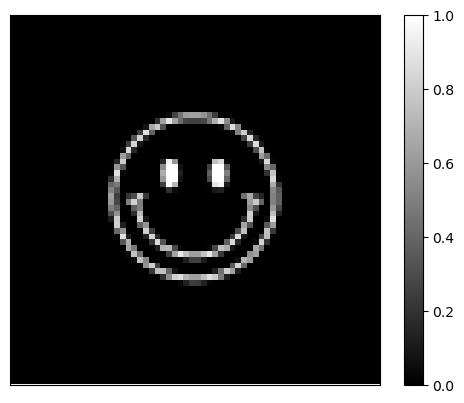

In [3]:
from PIL import Image

SMILEY_IMAGE = 'data/smiley-face-svg-rogne.jpg'
img = Image.open(SMILEY_IMAGE)
smiley=np.zeros([512,512])
smiley[256-128:256+128,256-128:256+128] = 1.0*(np.asarray(img)[:,:,0]<128)

# de zoom at the xsize scale
smiley=np.sum(np.sum(smiley.reshape(xsize,512//xsize,xsize,512//xsize),3),1)/(512/xsize)**2
plt.imshow(smiley,cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])

# compute noise population

In [4]:
noise=ampnoise*np.random.randn(nnoise,xsize,xsize)

# Define the Scaterring Covariance statistics

In [5]:
import foscat.scat_cov2D as sc
print('Work with ScatCov')
try:
    import torch
    print(torch.__version__)
    print('Use Torch')
    BACKEND='torch'
except:
    print('Use Tensorflow')
    BACKEND='tensorflow'
    
scat_op=sc.funct(BACKEND=BACKEND)

Work with ScatCov
2.7.1
Use Torch


## define the statistics

the eval_scat function defines how the statistics are computed using foscat.

In [6]:
# compute statistics for the smiley and the smiley+noise
data=smiley+np.random.randn(smiley.shape[0],smiley.shape[1])*ampnoise

Text(0.5, 1.0, 'Measured data')

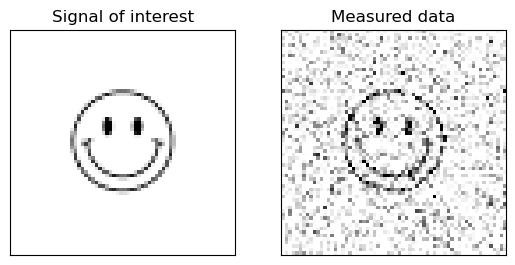

In [7]:

# shows both pictures

plt.subplot(1,2,1)
plt.imshow(smiley,vmin=0,vmax=1,cmap='Grays')
plt.xticks([])
plt.yticks([])
plt.title('Signal of interest')
plt.subplot(1,2,2)
plt.imshow(data,vmin=0,vmax=1,cmap='Grays')
plt.xticks([])
plt.yticks([])
plt.title('Measured data')

In [8]:
edge=False

# \Phi(d) \simeq \Phi(u + n),
def The_loss(x,scat_operator,args,return_all=False):

    ref  = args[0]
    noise= args[1]

    learn=scat_operator.scattering_cov(x+noise,edge=edge)
    
    learn=scat_operator.backend.bk_reduce_mean(learn,0)
    
    loss=scat_operator.reduce_mean(scat_operator.square(ref-learn))
    return loss

# \Phi(d,u) \simeq \Phi(u + n,u),
def The_lossX(x,scat_operator,args,return_all=False):

    im   = args[0]
    noise= args[1]

    ref=scat_operator.scattering_cov(im,data2=x,edge=edge)[0]
    
    learn=scat_operator.scattering_cov(x+noise,data2=x,edge=edge)
    learn=scat_operator.backend.bk_reduce_mean(learn-ref,0)
    
    loss=scat_operator.reduce_mean(scat_operator.square(learn))
    return loss

ref=scat_op.scattering_cov(data,edge=edge)[0]

in_data=scat_op.backend.bk_cast(data[None,:,:])

loss=synthe.Loss(The_loss,scat_op,ref,scat_op.backend.bk_cast(noise))

lossX=synthe.Loss(The_lossX,scat_op,scat_op.backend.bk_cast(data[None,:,:]),
                    scat_op.backend.bk_cast(noise))

# define the foscat synthesis using the two previous loss
sy = synthe.Synthesis([loss,lossX])

clean_map=sy.run(in_data,EVAL_FREQUENCY=30,NUM_EPOCHS = 300)

clean_map=scat_op.to_numpy(clean_map)

Total number of loss  2
Itt      0 L=  0.000527 (   0.00104   1.46e-05 ) 0.442s 
Itt     30 L=  3.75e-05 (  4.88e-05   2.62e-05 ) 10.582s 
Itt     60 L=  2.35e-05 (  3.67e-05   1.03e-05 ) 9.090s 
Itt     90 L=  2.16e-05 (  3.47e-05   8.55e-06 ) 8.963s 
Itt    120 L=  2.11e-05 (  3.41e-05   8.14e-06 ) 9.098s 
Itt    150 L=  2.09e-05 (  3.38e-05   7.95e-06 ) 9.288s 
Itt    180 L=  2.08e-05 (  3.37e-05   7.85e-06 ) 9.285s 
Itt    210 L=  2.07e-05 (  3.36e-05   7.84e-06 ) 9.592s 
Itt    240 L=  2.07e-05 (  3.35e-05   7.81e-06 ) 9.596s 
Itt    270 L=  2.06e-05 (  3.35e-05   7.78e-06 ) 9.302s 
Itt    300 L=  2.06e-05 (  3.34e-05    7.8e-06 ) 9.338s 
Final Loss  2.0593062799889594e-05


Input noise Level 0.302, Output noise Level 0.124, Gain ratio 2.43


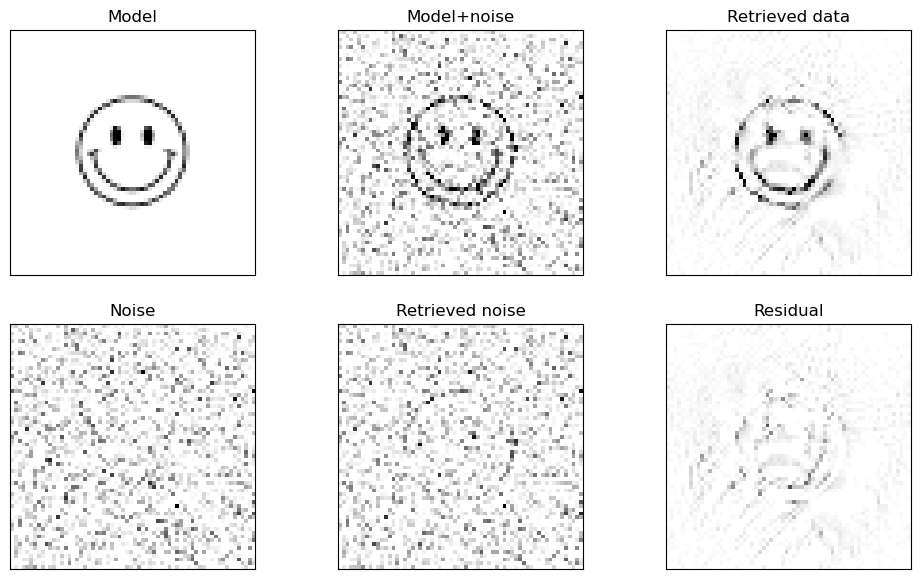

In [9]:
# let's have a look after the first epoch
def draw_pict(value,order,title,cmap='Greys'):
    plt.subplot(2,3,1+order)
    plt.title(title)
    plt.imshow(value,vmin=0,vmax=1,cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    
plt.figure(figsize=(12,7))
draw_pict(smiley,0,'Model')
draw_pict(data,1,'Model+noise')
draw_pict(clean_map[0],2,'Retrieved data')
draw_pict(data-smiley,3,'Noise')
draw_pict(data-clean_map[0],4,'Retrieved noise')
draw_pict(clean_map[0]-smiley,5,'Residual')

a=np.std(data-smiley)
b=np.std(smiley-clean_map[0])
print("Input noise Level %.3f, Output noise Level %.3f, Gain ratio %.2f"%(a,b,a/b))